In [1]:
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

# Fetch Data from Youtube API

## Fetch Video IDs from Youtube Search Queries

In [4]:
# Specify the path to txt file containing the Youtube API keys
api_path = "../keys/api_key_youtube.txt"

# Select an API key
api_key_number = 6

# Get api_key text
with open(api_path, 'r') as file:
    api_key = str(file.read()).split('\n')[api_key_number].split(':')[1].strip()

In [5]:
# Queries to youtube search
queries = [
    "What is artificial intelligence?",
    "Artificial intelligence applications in healthcare",
    "AI in autonomous vehicles",
    "Machine learning vs deep learning",
    "Artificial intelligence in finance",
    "How does AI work?",
    "Top AI tools for data science",
    "Artificial intelligence in robotics",
    "AI-driven innovation in business",
]

# Parameters for query
params = {
    'part': 'snippet',
    'type': 'video',
    'maxResults': 50,
    'key': api_key,
    'order': 'viewCount',
    'videoDuration': 'any',
    'regionCode': 'US'
}

In [6]:
import requests

# Function for fetching
def fetch_search_videos(api_key, params, query, max_results=500):

    url = 'https://www.googleapis.com/youtube/v3/search'
    params['q'] = query
    params['maxResults'] = min(max_results, 50) 
    params['key'] = api_key

    response = requests.get(url, params=params)
    all_results = response.json()['items']
    page_info = response.json()['pageInfo']['totalResults']
    print(f'total video results: {page_info}')

    next_page_token = response.json().get('nextPageToken')
    
    # Keep fetching until reaching the limit indicated
    while next_page_token and len(all_results) < max_results:
        params['pageToken'] = next_page_token
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            results = response.json()
            all_results.extend(results['items'])
            next_page_token = results.get('nextPageToken')
        else:
            print(f"Error: {response.status_code}")
            break

    return all_results[:max_results]

## Get Video Metadata from Video IDs

In [7]:
# Fetch video metadata
def fetch_video_metadata(video_id, api_key):
    url = f"https://www.googleapis.com/youtube/v3/videos?part=snippet,statistics,contentDetails&id={video_id}&key={api_key}"
    response = requests.get(url).json()
    if 'items' in response and len(response['items']) > 0:
        return(response['items'])
    else:
        return None

In [52]:
# Create dataframe from 
df_video_id = pd.read_csv('../data/raw_data/df_video_search_ids_ai.csv')
video_id_list = set(df_video_id['video_id'])
len(video_id_list)

2927

In [53]:
# Collect the data applying the function
video_info_test = [fetch_video_metadata(id, api_key) for id in video_id_list]
video_info_test[0]

[{'kind': 'youtube#video',
  'etag': 'gBsM0Z0XOxaNkxdeny2V0wwGOWs',
  'id': 'U8o8T83a0ME',
  'snippet': {'publishedAt': '2024-08-18T00:00:22Z',
   'channelId': 'UCCQAwA0n5CuehCmuSO7JTEg',
   'title': 'Meet Sophia: The AI-powered Social Robot Changing the Game #talkshow',
   'description': 'In this video, we introduce Sophia, a social robot with advanced artificial intelligence. Join us as we delve into the fascinating world of Hanson Robotics and their groundbreaking visual data processing software.',
   'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/U8o8T83a0ME/default.jpg',
     'width': 120,
     'height': 90},
    'medium': {'url': 'https://i.ytimg.com/vi/U8o8T83a0ME/mqdefault.jpg',
     'width': 320,
     'height': 180},
    'high': {'url': 'https://i.ytimg.com/vi/U8o8T83a0ME/hqdefault.jpg',
     'width': 480,
     'height': 360},
    'standard': {'url': 'https://i.ytimg.com/vi/U8o8T83a0ME/sddefault.jpg',
     'width': 640,
     'height': 480},
    'maxres': {'url': 'ht

In [57]:
# Extract video info from JSON and create a dataframe
def get_video_metadata(video_response):
    
    if video_response == None:
        return None
    
    video_metadata = video_response[0]

    if video_metadata and len(video_metadata) > 0:
        video_info = {
                    "videoId": video_metadata['id'],
                    "title": video_metadata['snippet']['title'],
                    "channelId": video_metadata['snippet']['channelId'],
                    "description": video_metadata['snippet']['description'],
                    "publishedAt": video_metadata['snippet']['publishedAt'],
                    "thumbnail_url": video_metadata['snippet']['thumbnails']['default']['url'],
                    "tags": video_metadata['snippet'].get('tags', []),
                    "live_broadcast": video_metadata['snippet']['liveBroadcastContent'],
                    "categoryId": video_metadata['snippet']['categoryId'],
                    "viewCount": video_metadata['statistics'].get('viewCount', 0),
                    "likeCount": video_metadata['statistics'].get('likeCount', 0),
                    "commentCount": video_metadata['statistics'].get('commentCount', 0),
                    "licensed": video_metadata['contentDetails']['licensedContent'],
                    "duration": video_metadata['contentDetails']['duration'],
                    "caption": video_metadata['contentDetails']['caption'],
                    }
        return(video_info)
    else:
        return None   

# Apply the function
video_metadata_test = [get_video_metadata(video_info_test[n]) for n in range(len(video_id_list))]

# Remove None files
video_metadata_test = [video for video in video_metadata_test if video != None]

# Create a dataframe from the output
df_video = pd.DataFrame(video_metadata_test)
df_video.head(5)

,videoId,title,channelId,description,publishedAt,thumbnail_url,tags,live_broadcast,categoryId,viewCount,likeCount,commentCount,licensed,duration,caption
0,U8o8T83a0ME,Meet Sophia: The AI-powered Social Robot Chang...,UCCQAwA0n5CuehCmuSO7JTEg,"In this video, we introduce Sophia, a social r...",2024-08-18T00:00:22Z,https://i.ytimg.com/vi/U8o8T83a0ME/default.jpg,"[celebrities on talk shows, celebs banned from...",none,23,11,0,0,False,PT23S,false
1,r31jnE7pR-g,How To Use Your GPU for Machine Learning on Wi...,UC4x2XenGe1vgLj_w_xkwsLw,A quick guide on how to enable the use of your...,2020-08-29T21:36:13Z,https://i.ytimg.com/vi/r31jnE7pR-g/default.jpg,"[python, python3, jupyternotebook, jupyterlab,...",none,28,150040,1402,130,False,PT2M38S,true
2,JMUxmLyrhSk,Artificial Intelligence Full Course | Artifici...,UCkw4JCwteGrDHIsyIIKo4tQ,🔥 Machine Learning Engineer Masters Program (U...,2019-06-02T08:53:49Z,https://i.ytimg.com/vi/JMUxmLyrhSk/default.jpg,"[yt:cc=on, Artificial Intelligence Full Course...",none,27,3905480,76616,902,True,PT4H52M51S,true
3,vpOLiDyhNUA,What is a Neural Network | Neural Networks Exp...,UCkw4JCwteGrDHIsyIIKo4tQ,** Machine Learning Masters Program: https://w...,2019-08-30T13:00:12Z,https://i.ytimg.com/vi/vpOLiDyhNUA/default.jpg,"[yt:cc=on, neural network, neural networks, wh...",none,27,208402,4018,57,True,PT7M34S,false
4,5koExepUUL8,Artificial intelligence and Robotics will be i...,UCAmw2hwsF48T6qeLYlhkqjA,Artificial intelligence and Robotics will be i...,2023-10-19T15:14:18Z,https://i.ytimg.com/vi/5koExepUUL8/default.jpg,"[artificial intelligence and robotics, electiv...",none,27,2998,217,21,True,PT4M9S,false


Detect the language of the videos

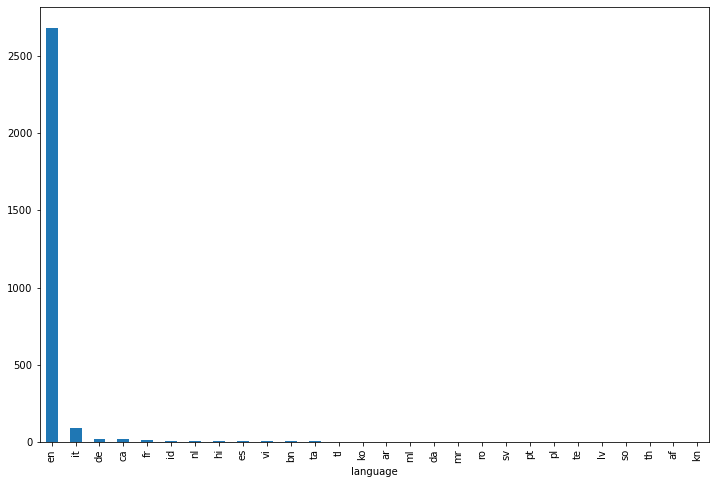

In [58]:
from langdetect import detect, DetectorFactory, LangDetectException
from nltk.corpus import stopwords

# Detect the language of the video
def detect_language(text):
    try:
        # Verificar si el texto es lo suficientemente largo
        if len(text.strip()) == 0:
            return None
        # Intentar detectar el idioma
        language = detect(text)
        return language
    except LangDetectException:
        # Si el texto es demasiado corto o no se puede detectar el idioma, devolver None
        return None

# Create column indicating the language of the video
df_video['language'] = df_video['title'].apply(detect_language)

plt.figure(figsize=(12,8))
df_video['language'].value_counts().plot(kind='bar')
plt.show();

In [59]:
# df_video.to_csv('../data/raw_data/df_video_ai.csv', index=False)

## Get Video Comments

In [100]:
import requests

# Fetch comments from video_id list
def fetch_top_comments(video_id, api_key, total_comments):
    url = 'https://www.googleapis.com/youtube/v3/commentThreads'
    params = {
        'part': 'snippet',
        'videoId': video_id,
        'order': 'relevance',
        'key': api_key
    }
    
    # Set the number of comments to fetch based on the number of total comments of video
    if total_comments <= 100:
        max_comments = total_comments
    elif total_comments <= 1000:
        max_comments = int(total_comments * 0.75)
    elif total_comments <= 10000:
        max_comments = int(total_comments * 0.2)
    else:
        max_comments = int(total_comments * 0.05)
    
    # Limit the maximum number of comments
    max_comments = min(max_comments, 1000)
    
    # Maximum allowed comments by API
    params['maxResults'] = 100  
    
    all_comments = []
    next_page_token = None

    while len(all_comments) < max_comments:
        if next_page_token:
            params['pageToken'] = next_page_token

        response = requests.get(url, params=params)
        if response.status_code == 200:
            results = response.json()
            for item in results['items']:
                comment = item['snippet']['topLevelComment']['snippet']
                comment_data = {
                    'comment_id': item['id'],
                    'author': comment['authorDisplayName'],
                    'author_channel_id': comment['authorChannelId']['value'],
                    'text': comment['textDisplay'],
                    'like_count': comment['likeCount'],
                    'published_at': comment['publishedAt'],
                    'updated_at': comment['updatedAt'],
                    'totalReplyCount': item['snippet']['totalReplyCount'],
                    'video_id': video_id
                }
                all_comments.append(comment_data)
            
            next_page_token = results.get('nextPageToken')
            
            if not next_page_token or len(all_comments) >= max_comments:
                break
        else:
            print(f"Error: {response.status_code}")
            break

    return all_comments[:max_comments]

In [101]:
# Get the videos with comments
df_video['commentCount'] = df_video['commentCount'].astype('int64')

# Create a new dataframe
df_clean = df_video[df_video['commentCount'] > 0].reset_index().copy()

Fetch the comments from the videos in parts

In [116]:
top_comments_1 = [fetch_top_comments(df_clean['videoId'][n], api_key, df_clean['commentCount'][n]) for n in range(0, len(df_clean[:500]))]

In [132]:
top_comments_2 = [fetch_top_comments(df_clean['videoId'][n], api_key, df_clean['commentCount'][n]) for n in range(500, 1000)]

In [134]:
top_comments_3 = [fetch_top_comments(df_clean['videoId'][n], api_key, df_clean['commentCount'][n]) for n in range(1000, 1500)]

In [136]:
top_comments_4 = [fetch_top_comments(df_clean['videoId'][n], api_key, df_clean['commentCount'][n]) for n in range(1500, len(df_clean))]

In [190]:
# Group all comments into a list
nested_list = [top_comments_1, top_comments_2, top_comments_3, top_comments_4]
flat_list = [item for sublist in nested_list for item in sublist]
top_comments = [item for sublist in flat_list for item in sublist]

# Create dataframe
df_top_comments = pd.DataFrame(top_comments)
df_top_comments.head()

# Save the dataframe
# df_top_comments.to_csv('../data/raw_data/df_comments_video_ai.csv', index=False)

## Get video transcription

In [3]:
from youtube_transcript_api import YouTubeTranscriptApi

# Fetch transcripts from videos
def get_transcription(video_id):
    try:
        # Get the list of available transcripts for the video
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)

        # Attempt to find any generated transcript in its original language
        generated_transcript = None
        original_language = None
        for transcript in transcript_list:
            if transcript.is_generated:
                generated_transcript = transcript
                original_language = transcript.language
                break

        if not generated_transcript:
            return None

        # Fetch and return the original transcription text in the original language
        text_formatted = " ".join([item['text'] for item in generated_transcript.fetch()])

        return {
            "video_id": video_id,
            "original_language": original_language,
            "transcription": text_formatted
        }

    except Exception as e:
        return None

# Load video
df_video_ai = pd.read_csv('../data/raw_data/df_video_ai.csv')

# Get the transcripts
transcript_test = get_transcription(df_video_ai['videoId'][0])

# Group the transcripst in a list
transcript_list = [get_transcription(id) for id in df_video_ai['videoId']]

In [173]:
# Remove the None values
clean_list_transcript = [item for item in transcript_list if item is not None]
clean_list_transcript[0]

{'video_id': 'qtlUwwtvuEg',
 'original_language': 'English (auto-generated)',
 'transcription': "[Music] thank you hello everyone I hope you are doing great in the era of AI welcome to Guru Tech Solutions Welcome to our video on 12 free AI tools for academic researchers and students with the rise of artificial intelligence these tools have become increasingly important in research and education they can help you automate repetitive tasks analyze data more efficiently and create powerful models that can accelerate your research in this video we will explore 12 most popular and useful free AI tools that are available to academic researchers and students let's Dive In AI tool number one first of all open your web browser and type chat.com thank you by entering it will take you to the official page of this first AI tool and the interface will appear like this you can see click get start here we have option to upload our PDF file by clicking here a window will appear to and ask to choose th

In [188]:
# Create and save the dataframe
df_transcript = pd.DataFrame(clean_list_transcript)
df_transcript.to_csv('../data/raw_data/df_transcript_original_ai.csv', index=False)
df_transcript.head()

,video_id,original_language,transcription
0,qtlUwwtvuEg,English (auto-generated),[Music] thank you hello everyone I hope you ar...
1,QaoDXYYtgK0,English (auto-generated),number three [Music] Facebook has enacted an e...
2,PqDwddEHswU,English (auto-generated),in this series we're going to introduce deep l...
3,B-Y7rnOa43w,English (auto-generated),this is how to earn money with AI and it's par...
4,vyit-1zKsZ4,English (auto-generated),when current Medical Science has run out of op...


Visualize the original language of the transcripts

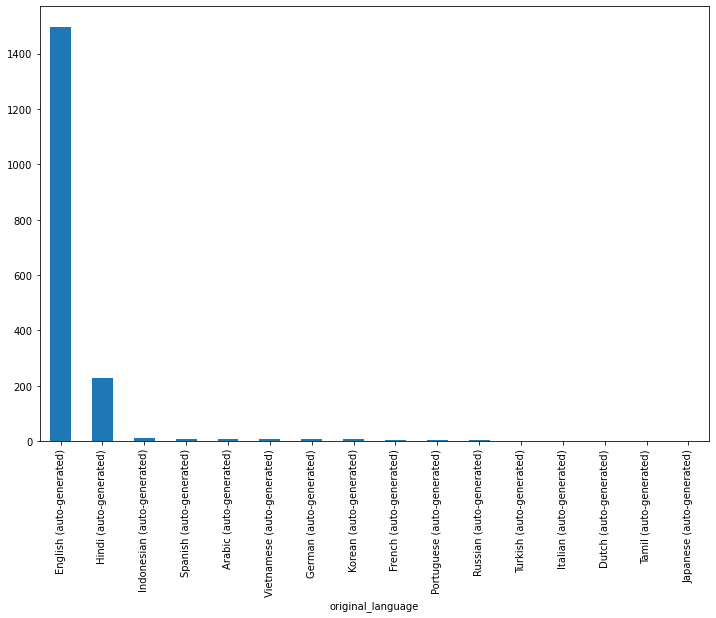

In [199]:
df_transcript = pd.read_csv('../data/raw_data/df_transcript_original_ai.csv')

plt.figure(figsize=(12,8))
df_transcript['original_language'].value_counts().plot(kind='bar')
plt.show();

## Get channel data

In [178]:
# Feth channel data from video_id list
def get_channel_data(api_key, channel_id):
    url_channel = f'https://youtube.googleapis.com/youtube/v3/channels?part=snippet,contentDetails,statistics&id={channel_id}&key={api_key}'

    response = requests.get(url_channel).json()

    # Check if the response contains the channel data
    if 'items' in response and len(response['items']) > 0:
        item = response['items'][0]
        channel_data = {
            'channel_id': item['id'],
            'title': item['snippet']['title'],
            'description': item['snippet']['description'],
            'published_at': item['snippet']['publishedAt'],
            'subscriber_count': item['statistics'].get('subscriberCount'),
            'video_count': item['statistics'].get('videoCount'),
            'view_count': item['statistics'].get('viewCount')
        }
        if 'country' in item['snippet'].keys():
            channel_data['region'] = item['snippet']['country']
        else:
            channel_data['region'] = None
        return channel_data
    else:
        print("No channel data found.")
        return None

# Get unique channel_id values
channel_id_list = set(df_video_ai['channelId'])   

# Get the channel info for each channel_id and create a list 
channel_data_list = [get_channel_data(api_key, id) for id in channel_id_list]

# Create and save the dataframe from the list
df_channel_data = pd.DataFrame(channel_data_list)
# df_channel_data.to_csv('../data/raw_data/df_channel_data_ai.csv', index=False)

Visualize the region of the channels

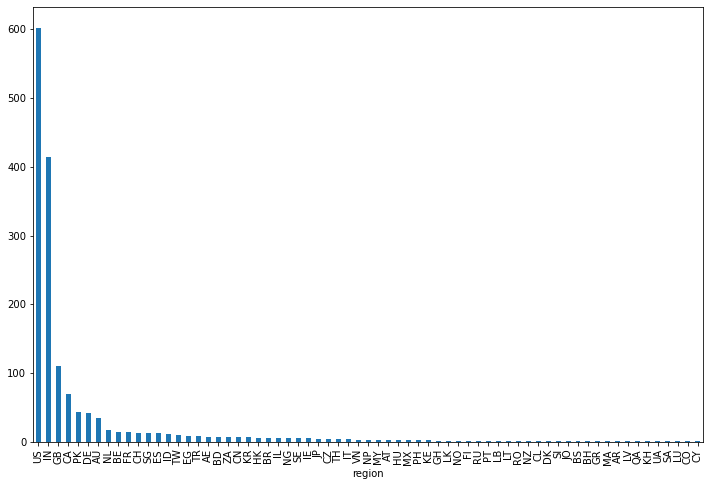

In [185]:
plt.figure(figsize=(12,8))
df_channel_data['region'].value_counts().plot(kind='bar')
plt.show();

# Clean Data

## Load Raw Data

In [2]:
folder = '../data/raw_data/'

df_categories = pd.read_csv(f'{folder}df_categories_ai.csv')
df_comments = pd.read_csv(f'{folder}df_comments_video_ai.csv', engine='python', on_bad_lines='skip')
df_transcript = pd.read_csv(f'{folder}df_transcript_full.csv')
df_videos = pd.read_csv(f'{folder}df_video_ai.csv')
df_search = pd.read_csv(f'{folder}df_video_search_ids_ai.csv')
df_channel = pd.read_csv(f'{folder}df_channel_data_ai.csv')

## Clean df_channel data

In [3]:
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   channel_id        2010 non-null   object
 1   title             2010 non-null   object
 2   description       1857 non-null   object
 3   published_at      2010 non-null   object
 4   subscriber_count  2010 non-null   int64 
 5   video_count       2010 non-null   int64 
 6   view_count        2010 non-null   int64 
 7   region            1583 non-null   object
dtypes: int64(3), object(5)
memory usage: 125.8+ KB


In [10]:
# Drop wrong fetch data 
df_channel.dropna(subset=['view_count'], inplace=True)

# Change to datetime
df_channel['published_at'] = pd.to_datetime(df_channel['published_at'])

# Export cleaned data
df_channel.to_csv('../data/clean_data/df_channel_data.csv', index=False)

# Show info cleaned
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   channel_id        2010 non-null   object             
 1   title             2010 non-null   object             
 2   description       1857 non-null   object             
 3   published_at      2010 non-null   datetime64[ns, UTC]
 4   subscriber_count  2010 non-null   int64              
 5   video_count       2010 non-null   int64              
 6   view_count        2010 non-null   int64              
 7   region            1583 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 125.8+ KB


## Clean df_video_data

In [ ]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   videoId         2711 non-null   object
 1   title           2711 non-null   object
 2   channelId       2711 non-null   object
 3   description     2535 non-null   object
 4   publishedAt     2711 non-null   object
 5   thumbnail_url   2711 non-null   object
 6   tags            2711 non-null   object
 7   live_broadcast  2711 non-null   object
 8   categoryId      2711 non-null   int64 
 9   viewCount       2711 non-null   int64 
 10  likeCount       2711 non-null   int64 
 11  commentCount    2711 non-null   int64 
 12  licensed        2711 non-null   bool  
 13  duration        2711 non-null   object
 14  caption         2711 non-null   bool  
 15  language        2711 non-null   object
dtypes: bool(2), int64(4), object(10)
memory usage: 301.9+ KB


In [ ]:
import isodate

# Remove duplicated video 
df_videos.drop_duplicates(subset=['videoId'], keep='first', inplace=True)

# Convert ISO 8601 duration to a readable format (timedelta)
def convert_duration(duration_str):
    duration = isodate.parse_duration(duration_str)
    return duration.seconds

# Change duration to total seconds
df_videos['duration'] = df_videos['duration'].apply(convert_duration)

# Drop live broadcast column and Unnamed 0
df_videos.drop(columns=['live_broadcast'], inplace=True)

# Export the cleaned data
df_videos.to_csv('../data/clean_data/df_video_data.csv', index=False)

df_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   videoId        2711 non-null   object
 1   title          2711 non-null   object
 2   channelId      2711 non-null   object
 3   description    2535 non-null   object
 4   publishedAt    2711 non-null   object
 5   thumbnail_url  2711 non-null   object
 6   tags           2711 non-null   object
 7   categoryId     2711 non-null   int64 
 8   viewCount      2711 non-null   int64 
 9   likeCount      2711 non-null   int64 
 10  commentCount   2711 non-null   int64 
 11  licensed       2711 non-null   bool  
 12  duration       2711 non-null   int64 
 13  caption        2711 non-null   bool  
 14  language       2711 non-null   object
dtypes: bool(2), int64(5), object(8)
memory usage: 280.8+ KB


## Clean df_comments_video

In [ ]:
df_comments.info()
pd.isnull(df_comments).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185382 entries, 0 to 185381
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   comment_id         185382 non-null  object 
 1   author             185003 non-null  object 
 2   author_channel_id  185109 non-null  object 
 3   text               185109 non-null  object 
 4   like_count         184944 non-null  float64
 5   published_at       184944 non-null  object 
 6   updated_at         184779 non-null  object 
 7   totalReplyCount    184779 non-null  float64
 8   video_id           184779 non-null  object 
dtypes: float64(2), object(7)
memory usage: 12.7+ MB


comment_id             0
author               379
author_channel_id    273
text                 273
like_count           438
published_at         438
updated_at           603
totalReplyCount      603
video_id             603
dtype: int64

In [ ]:
# Drop Nan values
df_comments.dropna(inplace=True)

# Transform data to correct type
df_comments['like_count'] = df_comments['like_count'].astype('float64')
df_comments['published_at'] = pd.to_datetime(df_comments['published_at'])
df_comments['updated_at'] = pd.to_datetime(df_comments['updated_at'])

# Export cleaned data
df_comments.to_parquet('../data/clean_data/df_comments_video.parquet', index=False)

df_comments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184673 entries, 0 to 185381
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   comment_id         184673 non-null  object             
 1   author             184673 non-null  object             
 2   author_channel_id  184673 non-null  object             
 3   text               184673 non-null  object             
 4   like_count         184673 non-null  float64            
 5   published_at       184673 non-null  datetime64[ns, UTC]
 6   updated_at         184673 non-null  datetime64[ns, UTC]
 7   totalReplyCount    184673 non-null  float64            
 8   video_id           184673 non-null  object             
dtypes: datetime64[ns, UTC](2), float64(2), object(5)
memory usage: 14.1+ MB


In [ ]:
df_comments = pd.read_parquet('../data/clean_data/df_comments_video.parquet')

## Clean df_transcript

In [ ]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           1787 non-null   object
 1   original_language  1787 non-null   object
 2   transcription      1787 non-null   object
 3   language           1787 non-null   object
 4   0                  291 non-null    object
dtypes: object(5)
memory usage: 69.9+ KB


In [ ]:
# Drop duplicated values
df_transcript.drop_duplicates(subset=['video_id'], inplace=True)

# Clean language values
def get_cleaned_name(str):
    return str.split(' ')[0].strip().lower()

df_transcript['language'] = df_transcript['original_language'].apply(get_cleaned_name)
df_transcript.rename(columns={'0': 'translation'}, inplace=True)
df_transcript.loc[df_transcript['language'] != 'english', 'transcription'] = df_transcript['translation']

# Drop unnecessary columns
df_transcript.drop(columns=['original_language', 'translation'], inplace=True)

# Export dataframe
df_transcript.to_csv('../data/clean_data/df_transcript_original.csv')

df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   video_id       1787 non-null   object
 1   transcription  1787 non-null   object
 2   language       1787 non-null   object
dtypes: object(3)
memory usage: 42.0+ KB


# Text Preprocess: Normalize comments and transcriptions

## Load Clean Data

In [ ]:
folder = '../data/clean_data/'

df_categories = pd.read_csv(f'{folder}df_categories.csv')
df_comments = pd.read_parquet(f'{folder}df_comments_video.parquet')
df_transcript = pd.read_csv(f'{folder}df_transcript_original.csv')
df_videos = pd.read_csv(f'{folder}df_video_data.csv')
df_channel = pd.read_csv(f'{folder}df_channel_data.csv')

Creating the `preprocess_text` function to apply it to `df_comments` and `df_transcripts`

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Download NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')

# Initialise lemmatizer
lemmatizer = WordNetLemmatizer()

# Load english stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ivanseldasp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ivanseldasp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocess `df_transcripts` and export the clean dataframe

In [ ]:
# Load transcript data
df_transcript = pd.read_csv('../data/clean_data/df_transcript_original.csv')

# Preprocess transcripts
df_transcript['clean_text'] = df_transcript['transcription'].apply(preprocess_text)

In [ ]:
# Export data
df_transcript.to_csv('../data/clean_data/df_transcript_original.csv', index=False)

Preprocess `df_comments` and export the clean dataframe

In [ ]:
# Apply function to english comments
df_comments['clean_text'] = df_comments['text'].apply(preprocess_text)

# Export the data
df_comments.to_parquet('../data/clean_data/df_comments_video.parquet', index=False)

Create a wordcloud for each comment from `df_comments`

In [ ]:
def get_comments_from_video(df, video_id):
    comments_list = []
    for comment in df[df['video_id'] == video_id]['clean_text']:
        if type(comment) == type('string'):
            comments_list.append(comment + '\n')
    joined_list = ' '.join(comments_list).strip()
    return(joined_list)

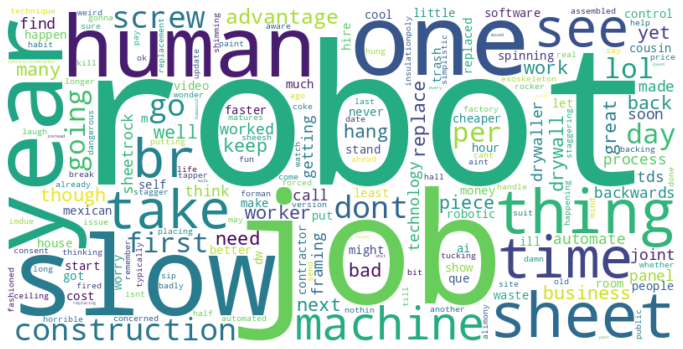

top 10 most frequent words
robot: 1.0000
job: 0.6818
slow: 0.5000
one: 0.4091
year: 0.4091
human: 0.4091
sheet: 0.3636
thing: 0.3636
time: 0.3182
take: 0.2727


In [ ]:
from wordcloud import WordCloud

video = df_comments['video_id'].iloc[np.random.randint(0, len(df_comments))]

comments = get_comments_from_video(df_comments, video)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)

# Print wordcloud graph
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Extract top 10 most frequent words and frequency
word_frequencies = wordcloud.words_
top_10_words = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:10]

print(f'top 10 most frequent words')
for word, freq in top_10_words:
    print(f"{word}: {freq:.4f}")

Merge dataframe with clean comments and clean transcriptions

In [ ]:
# Create new dataframe
df_content = df_transcript.copy()
if 'Unnamed: 0' in df_content.keys():
    df_content.drop(columns='Unnamed: 0', inplace=True)

# Get unique video_ids
video_id_list = list(set(df_comments['video_id']))

# Get all coments from video id in a dataframe
df_wordcloud = []
for id in video_id_list:
    word_list = {
        'video_id': id,
        'comment_list': get_comments_from_video(df_comments, id)
    }
    df_wordcloud.append(word_list)
df_wordcloud = pd.DataFrame(df_wordcloud)

# Merge both dataframes to get Content dataframe
df_content = df_content.merge(df_wordcloud, on='video_id', how='left')
df_content.head()

,video_id,transcription,language,clean_text,comment_list
0,qtlUwwtvuEg,[Music] thank you hello everyone I hope you ar...,english,music thank hello everyone hope great era ai w...,great videohelpful\n thank well explained vide...
1,QaoDXYYtgK0,number three [Music] Facebook has enacted an e...,english,number three music facebook enacted emergency ...,quotthey invented code languagequot man thats ...
2,PqDwddEHswU,in this series we're going to introduce deep l...,english,series going introduce deep learning least per...,brian douglas hero\n learned far sitting couch...
3,B-Y7rnOa43w,this is how to earn money with AI and it's par...,english,earn money ai part two let go want create kind...,oh im going try\n brilliant
4,vyit-1zKsZ4,when current Medical Science has run out of op...,english,current medical science run option doctor dont...,locked syndrome lateral amyloid multiple scler...


Export Content dataframe (comments and transcripts merged)

In [ ]:
df_content.to_csv('../data/clean_data/df_content.csv', index=False)

# Translate Comments to English

Text(0.5, 1.0, 'Videos with n_comments')

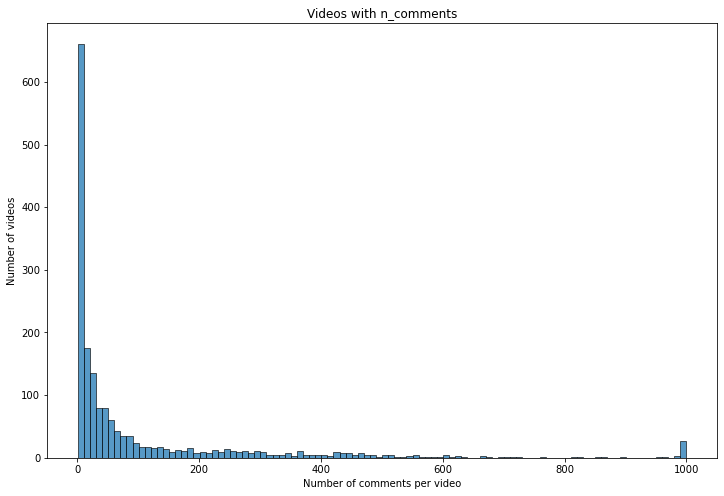

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.histplot(df_comments['video_id'].value_counts(), bins=100, kde=False)
plt.xlabel('Number of comments per video')
plt.ylabel('Number of videos')
plt.title('Videos with n_comments')

In [ ]:
from langdetect import detect, DetectorFactory, LangDetectException
from nltk.corpus import stopwords

# Create a column with language detected
def detect_language(text):
    try:
        # Check if the text is long enough
        if len(text.strip()) == 0:
            return None
        language = detect(text)
        return language
    except LangDetectException:
        return None

In [ ]:
df_comments['language'] = df_comments['text'].apply(detect_language)

# Translate all non-english comments to english

In [1]:
from deep_translator import GoogleTranslator

def translate_text(text, target_language='en'):
    translator = GoogleTranslator(source='auto', target=target_language)
    return translator.translate(text)

In [ ]:
# Translate non-english comments to english
df_comments['translation'] = df_comments[df_comments['language'] != 'en']['text'].apply(translate_text)

In [ ]:
df_comments[df_comments['language'] != 'en']['text'].iloc[:10].apply(translate_text)

0       great video,helpful.
10                   Awesome
11      ultimate information
15            important one.
20       very fruitful video
22                 Excellent
24                     great
27                   amazing
29    Alhamdulillah. perfect
31            highly amazing
Name: text, dtype: object

In [ ]:
# df_comments.to_parquet('../data/clean_data/df_comments_video.parquet', index=False)